In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split

# Dataset

In [10]:
# df = pd.read_csv('mod_data_summary_end_only.csv')
df = pd.read_csv('mod_data_name_end_only.csv')
# df = pd.read_json('mod_data_desc_end_only.json')

# # Convert NaN into empty string
# df.fillna('', inplace=True)

print(df.isna().sum())
df

name                 0
endorsement_count    0
high                 0
dtype: int64


name  endorsement_count  \
0      Alexi CirTein a Stormcloak officer - A followe...                184   
1                             Ravien - Queen of the Bolt                196   
2              Nocturnals Craftable Armor -CBBE friendly               1295   
3                                     Solitude Expansion               4545   
4              Gradually Restorative Potions- Standalone                108   
...                                                  ...                ...   
29777              Luna - A Standalone Follower (ESP-FE)                 61   
29778  Anabella - High Poly Standalone Tank Follower ...                300   
29779                          Buoyant Armiger Armors SE                  1   
29780   Follow Me Darling - All Spouses Can Be Followers                 63   
29781                   aMidianBorn Content Addon SSE RU                  8   

       high  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
29777     0  
29778     1  
29779     0  
29780     0  
29781     0  

[29782 rows x 3 columns]

View some information regarding the dataset

In [3]:
df.groupby('high').describe()

endorsement_count                                                        \
                 count         mean          std    min    25%    50%    75%   
high                                                                           
0              16409.0    33.542629    27.231089    0.0   10.0   26.0   52.0   
1              13373.0  1480.063561  6255.763668  100.0  167.0  321.0  856.0   

                
           max  
high            
0         99.0  
1     223850.0

In [8]:
df['high'].value_counts()

0    16409
1    13373
Name: high, dtype: int64

## Treating Outliers
Mods that have more than 1000 endorsements will be considered as outliers

In [11]:
indexes_to_keep = []
with open('mod_indexes.txt', 'r') as f:
    temp = f.readlines()
    for x in temp:
        indexes_to_keep.append(int(x))

df_filtered = df[df.index.isin(indexes_to_keep)]
# Filter out mods with more than 1000 endorsements
df_filtered = df_filtered[(df_filtered['endorsement_count'] <= 1000)]

print(df_filtered['high'].value_counts())
df_filtered

0    14206
1     7230
Name: high, dtype: int64


name  endorsement_count  \
0      Alexi CirTein a Stormcloak officer - A followe...                184   
1                             Ravien - Queen of the Bolt                196   
9                                     Tamriel y mas alla                  6   
10     Ultimative Inventar Sortierung Special Edition...                275   
12                                    Blessing&#39;s Bay                 11   
...                                                  ...                ...   
29777              Luna - A Standalone Follower (ESP-FE)                 61   
29778  Anabella - High Poly Standalone Tank Follower ...                300   
29779                          Buoyant Armiger Armors SE                  1   
29780   Follow Me Darling - All Spouses Can Be Followers                 63   
29781                   aMidianBorn Content Addon SSE RU                  8   

       high  
0         1  
1         1  
9         0  
10        1  
12        0  
...     ...  
29777     0  
29778     1  
29779     0  
29780     0  
29781     0  

[21436 rows x 3 columns]

## Balancing the dataset
Oversampling will be performed

In [12]:
from dataset_preprocessor import perform_oversampling

print('Original data:')
print(df_filtered['high'].value_counts())

df_balanced = perform_oversampling(df_filtered)

print('-'*10)
print('After oversampling:')
print(df_balanced['high'].value_counts())

Original data:
0    14206
1     7230
Name: high, dtype: int64
----------
After oversampling:
0    14206
1    14206
Name: high, dtype: int64


## Train-test Split

In [13]:
seed = 69420

df_main = df_balanced

y = df_main['high']
x = df_main.drop(['high', 'endorsement_count'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=df_main['high'], random_state=seed)

x_train.head()

name
11836                    CFTO Carriage for Helgen Reborn
19557      Legacy of the Dragonborn - Main Menu Replacer
12468  Traducao brasileira para Path of Sorcery - Ass...
25407  Whiterun Battle Brothers CHS simple Chinese tr...
27500  Dawnguard SE - Vampire Castle - Slash - Vanill...

# BERT

## Model Setup

In [14]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [15]:
def create_summary_model(bert_preprocess, bert_encoder):
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural Network layers
    l = tf.keras.layers.Dropout(0.1, name='dropout') (outputs['pooled_output'])
    l = tf.keras.layers.Dense(128, activation='relu') (l)
    # l = tf.keras.layers.Dropout(0.1, name='dropout2') (l)
    l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

    # Construct final model
    return tf.keras.Model(inputs=[text_input], outputs=[l])

def create_name_model(bert_preprocess, bert_encoder):
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural Network layers
    l = tf.keras.layers.Dropout(0.1, name='dropout') (outputs['pooled_output'])
    l = tf.keras.layers.Dense(128, activation='relu') (l)
    # l = tf.keras.layers.Dropout(0.1, name='dropout2') (l)
    l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

    # Construct final model
    return tf.keras.Model(inputs=[text_input], outputs=[l])

def create_desc_model(bert_preprocess, bert_encoder):
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural Network layers
    l = tf.keras.layers.Dropout(0.1, name='dropout') (outputs['pooled_output'])
    l = tf.keras.layers.Dense(128, activation='relu') (l)
    # l = tf.keras.layers.Dropout(0.1, name='dropout2') (l)
    l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

    # Construct final model
    return tf.keras.Model(inputs=[text_input], outputs=[l])

model = create_name_model(bert_preprocess, bert_encoder)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

## Training

In [16]:
def train(
    model, 
    x,
    y, 
    val_split=0.2, 
    model_name:str = 'model',
    use_early_stopping:bool = True,
    use_tensorboard_callback:bool = True,
    tensorboard_path:str = './tensorboard_logs/',
    use_model_checkpoint:bool = False,
    use_csv_logger:bool = True,
    csv_path:str = './csv_logs/',
    checkpoint_freq:int = 1,
    checkpoint_path:str = './model_checkpoints/',
    epochs:int = 10, 
    verbose:int = 2,
    append_csv:bool= False,
):
    initial_epoch = 0

    # Create callbacks
    callbacks:list = []

    # Tensorboard
    if (use_tensorboard_callback):
        log_dir = tensorboard_path + model_name
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir, 
            histogram_freq=1,
            embeddings_freq=1,
            write_images=False,
        )
        callbacks.append(tensorboard_callback)
    # Early stopping
    if (use_early_stopping):
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-3 less"
            min_delta=1e-3,
            # "no longer improving" being further defined as "for at least 5 epochs"
            patience=5,
            verbose=1
        )
        callbacks.append(early_stopping_callback)
    # Model checkpoints
    if (use_model_checkpoint):
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            # Path where to save the model
            # The two parameters below mean that we will overwrite
            # the current checkpoint if and only if
            # the `loss` score has improved.
            # The saved model name will include the current epoch.
            filepath = checkpoint_path + model_name + '/',
            save_best_only=True,  # Only save a model if `val_loss` has improved.
            monitor="val_loss", 
            verbose=0,
            save_weights_only=True,
            save_freq = 'epoch'
        )
        callbacks.append(model_checkpoint_callback)
    # CSV Logger
    if (use_csv_logger):
        csv_logger = tf.keras.callbacks.CSVLogger(
            csv_path + model_name + '.csv',
            append=append_csv
        )
        callbacks.append(csv_logger)

        if (os.path.exists(csv_path + model_name + '.csv')):
            # Setup initial epoch
            df_test = pd.read_csv('model_checkpoints/name_bert_model/name_bert_model.csv')
            initial_epoch = df_test['epoch'].max() + 1
    
    # Train the model
    print('Begin training model...')
    return model.fit(
        x,
        y,
        validation_split = val_split,
        epochs = epochs,
        callbacks = callbacks,
        verbose = verbose,
        initial_epoch = initial_epoch
    )

In [17]:
model_name = 'name_bert_model'
graph_save_location = f'./model_checkpoints/{model_name}/{model_name}.png'
csv_path:str = f'./model_checkpoints/{model_name}/'
tensorboard_path:str = './model_checkpoints/tensorboard_logs/'
checkpoint_path:str = './model_checkpoints/'
use_tensorboard_callback = False
append_csv = True
val_split= 0.2
epochs = 50
test_predict_text = 'Sigil Stone Fix'     # Used to test singular input in the model
weight_path = f'model_checkpoints/{model_name}/'        # Path to previous trained weights. Leave as empty string to not use this feature
# weight_path = ''

# Load weights
if (append_csv and weight_path != ''):
    model.load_weights(weight_path)
# elif (append_csv and weight_path == ''):
#     # Delete csv file, as to record a new training session
#     filepath = csv_path + model_name + '.csv'
#     if os.path.exists(filepath):
#         os.remove(filepath)


# Training metrics
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),       # Original: 1e-4
    loss='binary_crossentropy',
    metrics=METRICS
)

history = train(
        model, 
        x_train,
        y_train ,
        val_split=val_split, 
        use_tensorboard_callback=use_tensorboard_callback,
        model_name=model_name, 
        use_model_checkpoint=True,
        verbose=1,
        epochs=epochs,
        append_csv=append_csv,
        csv_path = csv_path,
        tensorboard_path = tensorboard_path,
        checkpoint_path = checkpoint_path,
    )

Begin training model...
Epoch 24/50
569/569 [==============================] - 252s 419ms/step - loss: 0.6513 - accuracy: 0.6017 - precision: 0.5863 - recall: 0.6884 - val_loss: 0.6478 - val_accuracy: 0.6104 - val_precision: 0.5853 - val_recall: 0.7644
Epoch 25/50
569/569 [==============================] - 234s 411ms/step - loss: 0.6503 - accuracy: 0.6056 - precision: 0.5911 - recall: 0.6829 - val_loss: 0.6468 - val_accuracy: 0.6109 - val_precision: 0.5793 - val_recall: 0.8170
Epoch 26/50
569/569 [==============================] - 233s 409ms/step - loss: 0.6479 - accuracy: 0.6044 - precision: 0.5901 - recall: 0.6813 - val_loss: 0.6603 - val_accuracy: 0.5961 - val_precision: 0.6280 - val_recall: 0.4770
Epoch 27/50
569/569 [==============================] - 235s 413ms/step - loss: 0.6477 - accuracy: 0.6055 - precision: 0.5910 - recall: 0.6835 - val_loss: 0.6443 - val_accuracy: 0.6109 - val_precision: 0.5816 - val_recall: 0.7977
Epoch 28/50
569/569 [==============================] - 235s 

Graph training session

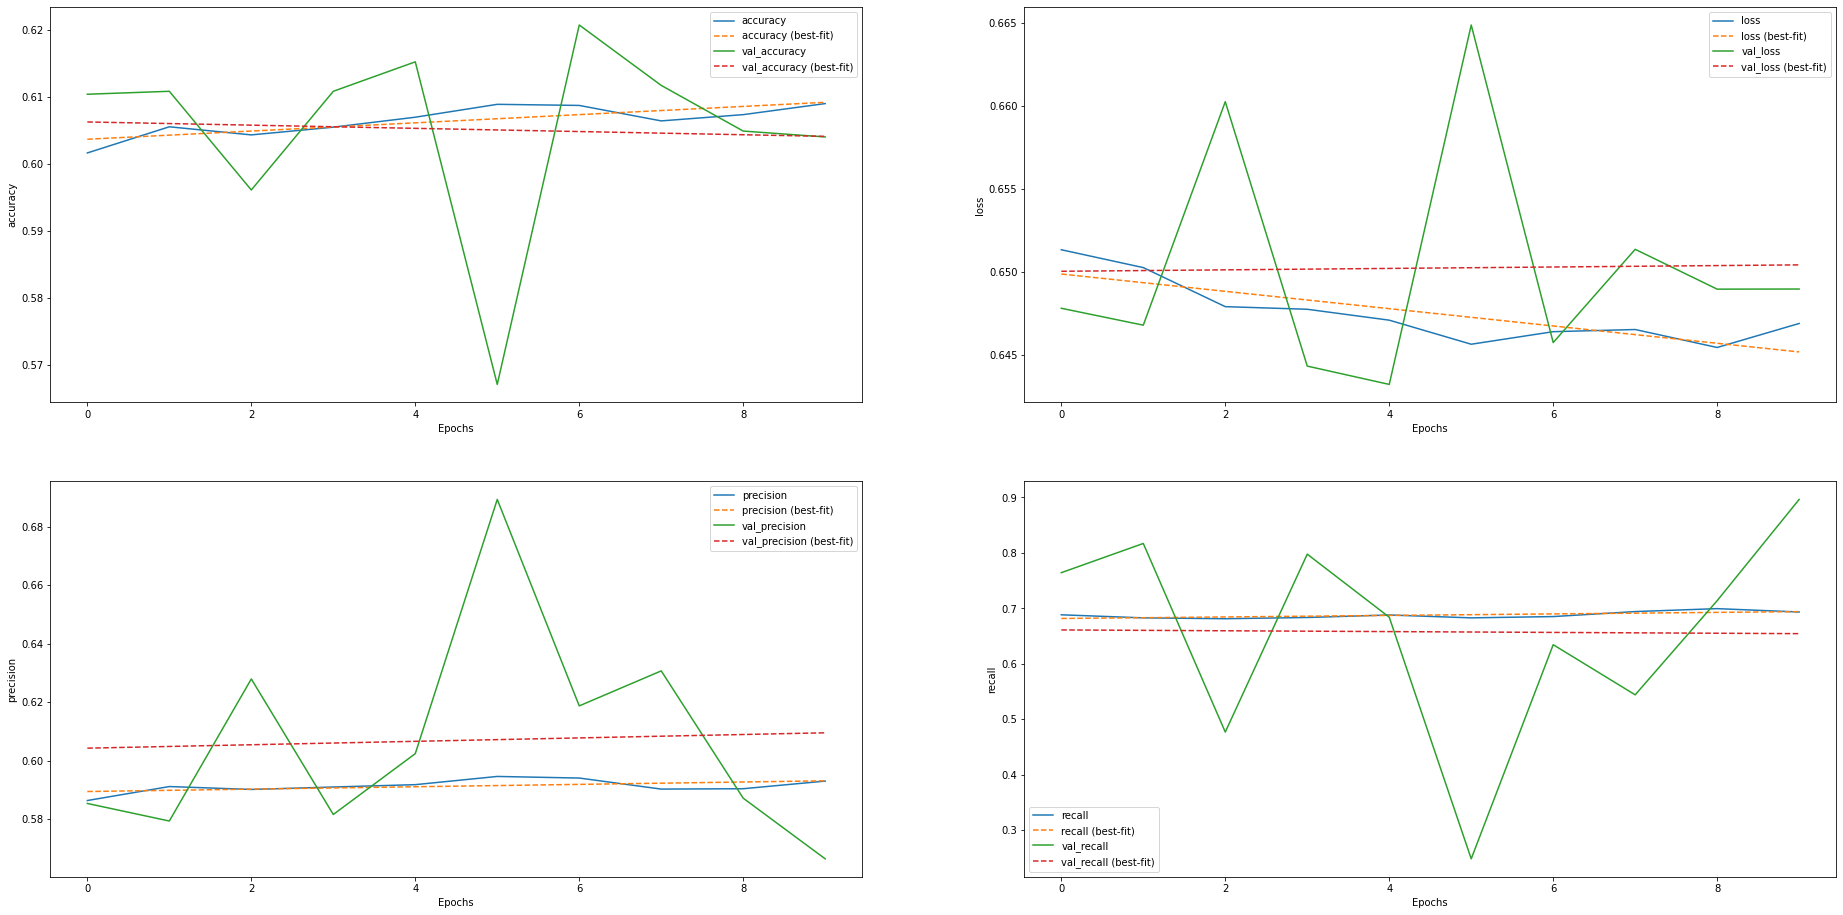

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    y = history.history[metric]
    y_val = history.history['val_'+metric]
    x = [i for i in range(len(y))]
    
    # m, b = np.polyfit(x, y, 1)
    # m_val, b_val = np.polyfit(x, y_val, 1)

    plt.plot(y)
    plt.plot(x, np.poly1d(np.poly1d(np.polyfit(x, y, 1))(x)), '--')
    plt.plot(y_val, '')
    plt.plot(x, np.poly1d(np.poly1d(np.polyfit(x, y_val, 1))(x)), '--')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'{metric} (best-fit)', 'val_'+metric, f'val_{metric} (best-fit)'])

plt.figure(figsize=(32, 16))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
plt.subplot(2, 2, 3)
plot_graphs(history, 'precision')
plt.subplot(2, 2, 4)
plot_graphs(history, 'recall')

plt.savefig(graph_save_location)

## Evaluation

In [19]:
model.evaluate(x_test, y_test)

178/178 [==============================] - 55s 310ms/step - loss: 0.6508 - accuracy: 0.6014 - precision: 0.5636 - recall: 0.8994


[0.6507857441902161,
 0.6014428734779358,
 0.5636163353919983,
 0.8993666172027588]

In [20]:
y_true = np.array(y_test.tolist())
y_pred = model.predict(x_test).flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)   # Change values into 1s or 0s

Create confusion matrix

Text(33.0, 0.5, 'Truth')

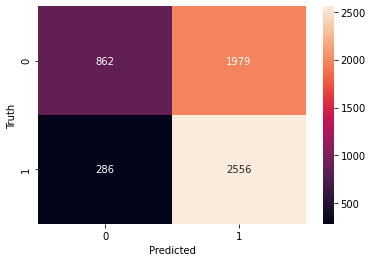

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_true, y_pred)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.30      0.43      2841
           1       0.56      0.90      0.69      2842

    accuracy                           0.60      5683
   macro avg       0.66      0.60      0.56      5683
weighted avg       0.66      0.60      0.56      5683



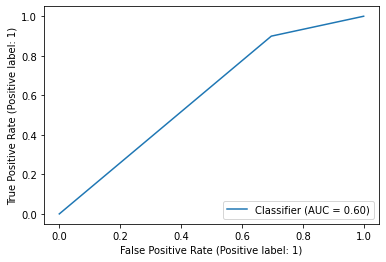

In [23]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true, y_pred)